# Apprentissage Profond : Projet Classification d'images 

Gonzalez Julia et Cadiou Hadrien MSS M2

Dans ce notebook, nous allons utiliser des réseaux de neurones afin de faire de la classification binaire d'images.
Les données sont des images satellites avec ou sans éolienne. 
Les images sont de taille 128x128 et sont en couleur. 

## 1 Prise en main des données

Visualisation des données

In [2]:
from tensorflow import keras
import tensorflow.keras.preprocessing.image as kpi

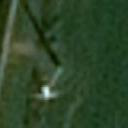

In [3]:
# Visualisation des données
import keras.preprocessing.image as kpi

# Chemin d'accès aux données
data_dir = 'C:/Projet_Local_ML_MSS/Projet-classement-airbus-data/Data_Projet_TP3_Defi_IA'
# error unicode --> chnager le sens des antislash

# Target
img = kpi.load_img(data_dir+'/train/target/C81820872.jpg')
img

## 2 Data Augmentation et Pré Traitement des données

Nous allons augmenter le volume d'images en appliquant : 
- Des rotations, 
- Translation horizontale aléatoire
- Translation verticale aléatoire
- Inclinaison aléatoire
- Zoom aléatoire
- Retournement horizontal aléatoire
- Mode de remplissage pour les transformations.
Cela nous permettra de limiter le surapprentissage. 

Ensuite nous allons créer trois générateurs : Un pour l'entraînement, un autre pour la validation et un dernier pour le test. 


In [6]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

warnings.filterwarnings("ignore")

In [7]:
# Importation de librairies
import numpy as np
import pandas as pd
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

import matplotlib.pyplot as plt

In [8]:
# Data Augmentation : 
train_datagen = kpi.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,         # Rotation aléatoire dans la plage de -40 à 40 degrés
    width_shift_range=0.2,    # Translation horizontale aléatoire
    height_shift_range=0.2,   # Translation verticale aléatoire
    shear_range=0.2,          # Inclinaison aléatoire
    zoom_range=0.2,           # Zoom aléatoire
    horizontal_flip=True,     # Retournement horizontal aléatoire
    fill_mode='nearest')       # Mode de remplissage pour les transformations

# Toutes les images sont normalisées en divisant l'intensité des pixels par 255
valid_datagen = kpi.ImageDataGenerator(rescale = 1./255)

# Paramètres
nb_classes = 2
batch_size= 1786
batch_size = 1000

# Taille des images
img_width = 128
img_height = 128

# Définition d'un générateur qui lira les images trouvées dans
# les sous-dossiers de data_dir+'/train', et génère indéfiniment
# des lots (batch) de données d'images (possiblement augmentées)

train_generator = train_datagen.flow_from_directory(
        data_dir+"/train/", 
        target_size=(img_width, img_height),  
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

# Ceci est un générateur similaire, pour des données de validation
# Il faut en amont créer un repertoire de validation
validation_generator = valid_datagen.flow_from_directory(
        data_dir+"/validation/",
        target_size=(img_width, img_height),  
        batch_size=batch_size,
        class_mode='categorical')

Found 58218 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [9]:

# Calcul des predictions pour chaque image sur l'ensemble de test
prediction_dir = data_dir+"/test/"
test_datagen = kpi.ImageDataGenerator(rescale=1./255)

# this is a similar generator, for test data
test_generator = test_datagen.flow_from_directory(
        prediction_dir,
        target_size=(img_width, img_height),
        batch_size=1,
        class_mode=None,
        shuffle=False)

test_generator.reset()

Found 5000 images belonging to 1 classes.


## 3 Réseau de neurones basique

Nous allons créer un modèle à partir d'un réseau de neurones. 

In [25]:
def A_model():
    # Réseau feedforward
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(img_width, img_height, 3)))
    # Couche de convolution avec 32 filtres de taille 5x5
    model.add(tf.keras.layers.Conv2D(32, (5, 5), activation='relu'))
    # Couche de maxpooling de taille 2x2
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Couche pour applatir le réseau (Grand vecteur)
    model.add(tf.keras.layers.Flatten())
    
    # Couche full-connected avec 2 sorties avec activation softmax
    model.add(tf.keras.layers.Dense(64, activation = 'relu'))
    #model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(32, activation = 'relu'))
    #model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(2, activation = 'softmax'))
    # Compilation du modèle
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

# Définition / construction du modèle
model = A_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 124, 124, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 123008)            0         
                                                                 
 dense (Dense)               (None, 64)                7872576   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                        

Nous allons maintenant entraîner le modèle sur 10 epochs.

In [26]:
# Taille des batch et nombre d'epoch
epochs = 10

# Ajouter le paramètre : validation_data=validation_generator)
# pour calculer la précision (accuracy) sur un répertoire de validation
history_A = model.fit(train_generator, validation_data=validation_generator, epochs=epochs)

Epoch 1/10
59/59 [==============================] - 711s 12s/step - loss: 1.0527 - accuracy: 0.6426 - val_loss: 0.4200 - val_accuracy: 0.8360
Epoch 2/10
59/59 [==============================] - 573s 10s/step - loss: 0.4342 - accuracy: 0.8187 - val_loss: 0.3183 - val_accuracy: 0.8812
Epoch 3/10
59/59 [==============================] - 27216s 469s/step - loss: 0.3791 - accuracy: 0.8432 - val_loss: 0.2913 - val_accuracy: 0.8826
Epoch 4/10
59/59 [==============================] - 642s 11s/step - loss: 0.3435 - accuracy: 0.8556 - val_loss: 0.2595 - val_accuracy: 0.8994
Epoch 5/10
59/59 [==============================] - 509s 9s/step - loss: 0.3221 - accuracy: 0.8638 - val_loss: 0.2620 - val_accuracy: 0.9014
Epoch 6/10
59/59 [==============================] - 523s 9s/step - loss: 0.3000 - accuracy: 0.8756 - val_loss: 0.2375 - val_accuracy: 0.9090
Epoch 7/10
59/59 [==============================] - 590s 10s/step - loss: 0.2848 - accuracy: 0.8798 - val_loss: 0.2459 - val_accuracy: 0.9012
Epoch

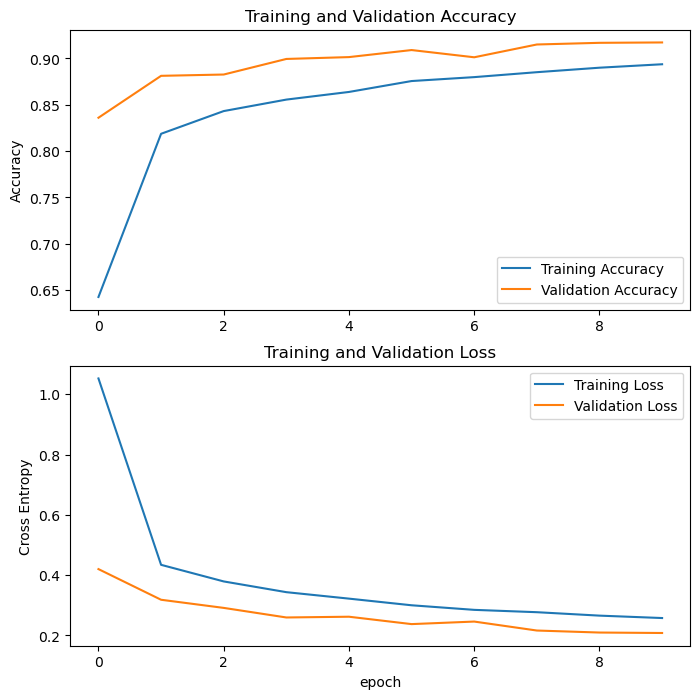

In [27]:
acc = history_A.history['accuracy']
val_acc = history_A.history['val_accuracy']

loss = history_A.history['loss']
val_loss = history_A.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Après l'entraînement, nous allons prédire les classes des images test et les conserver dans un csv. 

In [28]:
pred_test=history_A.model.predict(test_generator,verbose=1)

img_names = [w.replace('test_subfolder/','') for w in test_generator.filenames]
test_predictions = pd.read_csv(data_dir+'/template_predictions.csv', sep=";")
res = np.sort(test_predictions["name"])
pos = np.argsort(test_predictions["name"])
test_predictions["prediction"][pos] = pred_test.argmax(axis=-1)
pred = pred_test.argmax(axis=-1)

test_predictions.to_csv("pred_model_val_accuracy_0.9148.csv",index=False, sep="\t")

5000/5000 [==============================] - 54s 11ms/step


## 4 Réseau basique et Fine Tuning

In [29]:
history_A.model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(history_A.model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in history_A.model.layers[:fine_tune_at]:
  layer.trainable = False

base_learning_rate = 0.0001

Number of layers in the base model:  6


In [30]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 124, 124, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 123008)            0         
                                                                 
 dense (Dense)               (None, 64)                7872576   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                        

In [31]:
fine_tune_epochs = 5
total_epochs =  epochs + fine_tune_epochs

history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         initial_epoch=history_A.epoch[-1],
                         validation_data= validation_generator)

Epoch 10/15
59/59 [==============================] - 558s 9s/step - loss: 0.3615 - accuracy: 0.8949 - val_loss: 0.3170 - val_accuracy: 0.9172
Epoch 11/15
59/59 [==============================] - 507s 9s/step - loss: 0.3619 - accuracy: 0.8933 - val_loss: 0.3170 - val_accuracy: 0.9172
Epoch 12/15
59/59 [==============================] - 451s 8s/step - loss: 0.3608 - accuracy: 0.8939 - val_loss: 0.3170 - val_accuracy: 0.9172
Epoch 13/15
59/59 [==============================] - 291s 5s/step - loss: 0.3617 - accuracy: 0.8950 - val_loss: 0.3170 - val_accuracy: 0.9172
Epoch 14/15
59/59 [==============================] - 291s 5s/step - loss: 0.3622 - accuracy: 0.8944 - val_loss: 0.3170 - val_accuracy: 0.9172
Epoch 15/15
59/59 [==============================] - 290s 5s/step - loss: 0.3616 - accuracy: 0.8950 - val_loss: 0.3170 - val_accuracy: 0.9172


In [32]:
pred_test=history_fine.model.predict(test_generator,verbose=1)

img_names = [w.replace('test_subfolder/','') for w in test_generator.filenames]
test_predictions = pd.read_csv(data_dir+'/template_predictions.csv', sep=";")
res = np.sort(test_predictions["name"])
pos = np.argsort(test_predictions["name"])
test_predictions["prediction"][pos] = pred_test.argmax(axis=-1)
pred = pred_test.argmax(axis=-1)

test_predictions.to_csv("pred_model_tensorflow_val_accuracy_0.97.csv",index=False, sep="\t")

5000/5000 [==============================] - 34s 7ms/step


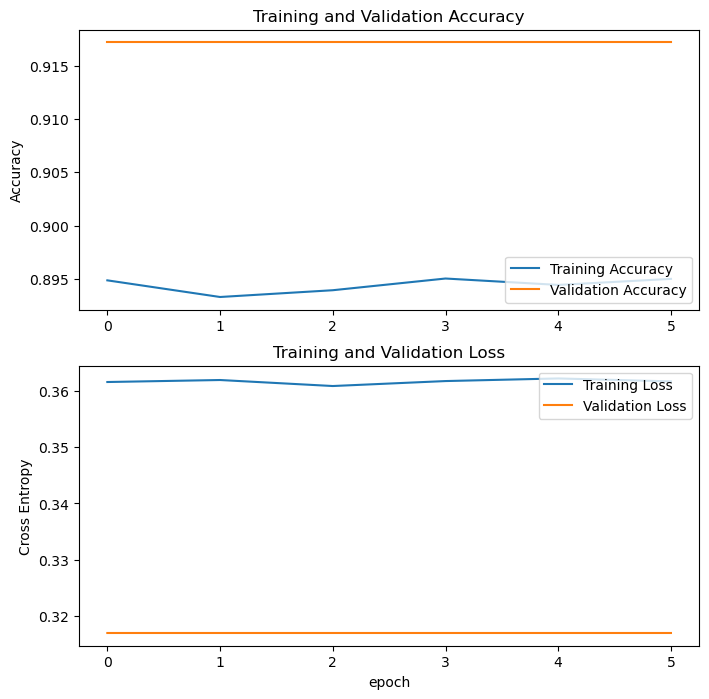

In [33]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Nous remarquons que la précision sur l'ensemble de validation reste inchangée.

## 5 Réseau de neurones pré-entraîné 

Nous allons maintenant utiliser un modèle pré-entraîné. Nous allons essayer plusieurs modèles pré-entrainés : 
- MobileNetV2
- Xception

### 5.1 : MobileNetV2

In [34]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_width, img_height, 3),
                                               include_top=False,
                                               weights='imagenet')

In [35]:
base_model.trainable = False

In [36]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_5[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[

In [47]:
 global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# feature_batch_average = global_average_layer(feature_batch)
# print(feature_batch_average.shape)

In [48]:
 prediction_layer = tf.keras.layers.Dense(2, activation = 'softmax')
# prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)

In [46]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [49]:
inputs = tf.keras.Input(shape=(img_width, img_height, 3))
# x = preprocess_input(x)
x = inputs
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [50]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_5  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01

In [51]:
epochs = 10

# Ajouter le paramètre : validation_data=validation_generator)
# pour calculer la précision (accuracy) sur un répertoire de validation
history_1 = model.fit(train_generator, validation_data=validation_generator, epochs=epochs)

Epoch 1/10
59/59 [==============================] - 1065s 18s/step - loss: 0.7043 - accuracy: 0.6494 - val_loss: 0.5078 - val_accuracy: 0.8400
Epoch 2/10
59/59 [==============================] - 821s 14s/step - loss: 0.5141 - accuracy: 0.8073 - val_loss: 0.3681 - val_accuracy: 0.8964
Epoch 3/10
59/59 [==============================] - 690s 12s/step - loss: 0.4176 - accuracy: 0.8518 - val_loss: 0.2983 - val_accuracy: 0.9116
Epoch 4/10
59/59 [==============================] - 607s 10s/step - loss: 0.3627 - accuracy: 0.8724 - val_loss: 0.2588 - val_accuracy: 0.9220
Epoch 5/10
59/59 [==============================] - 653s 11s/step - loss: 0.3255 - accuracy: 0.8849 - val_loss: 0.2340 - val_accuracy: 0.9258
Epoch 6/10
59/59 [==============================] - 638s 11s/step - loss: 0.3014 - accuracy: 0.8938 - val_loss: 0.2169 - val_accuracy: 0.9300
Epoch 7/10
59/59 [==============================] - 675s 11s/step - loss: 0.2811 - accuracy: 0.9002 - val_loss: 0.2043 - val_accuracy: 0.9334
Epoch

In [52]:
pred_test=history_1.model.predict(test_generator,verbose=1)


img_names = [w.replace('test_subfolder/','') for w in train_generator.filenames]
test_predictions = pd.read_csv(data_dir+'/template_predictions.csv', sep=";")
res = np.sort(test_predictions["name"])
pos = np.argsort(test_predictions["name"])
test_predictions["prediction"][pos] = pred_test.argmax(axis=-1)
pred = pred_test.argmax(axis=-1)
print(test_predictions[0:10])
test_predictions.to_csv("pred_model_val_accuracy_0.9356.csv",index=False, sep="\t")

5000/5000 [==============================] - 130s 26ms/step
     name  prediction
0   1.jpg         1.0
1   2.jpg         1.0
2   3.jpg         1.0
3   4.jpg         1.0
4   5.jpg         1.0
5   6.jpg         1.0
6   7.jpg         1.0
7   8.jpg         1.0
8   9.jpg         1.0
9  10.jpg         1.0


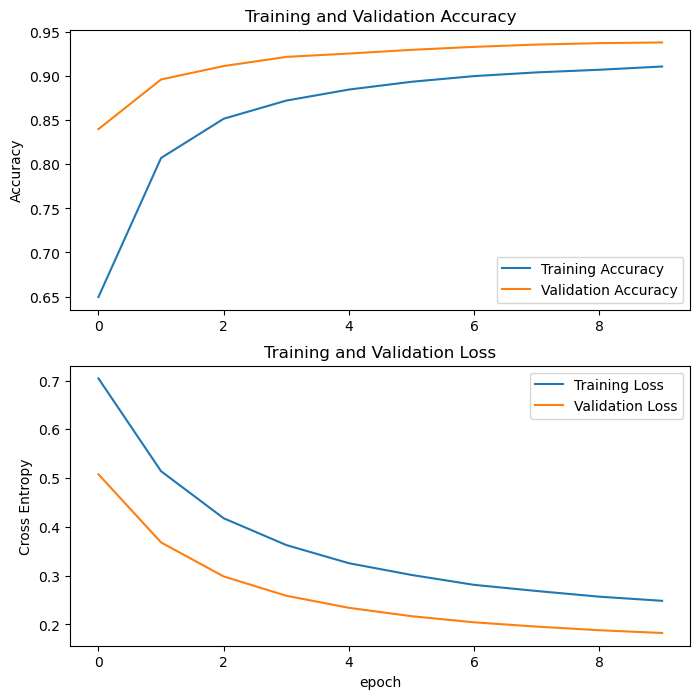

In [53]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

On a eu un temps de 121 minutes et 51 secondes avec mobilenetV2 pour 10 epochs

### 5.2 Modèle Xception

In [54]:
base_model = tf.keras.applications.Xception(input_shape=(img_width, img_height, 3),
                                               include_top=False,
                                               weights='imagenet')

In [55]:
base_model.trainable = False

In [56]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 63, 63, 32)           864       ['input_7[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 63, 63, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 63, 63, 32)           0         ['block1_conv1_bn[0][0]

In [57]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# feature_batch_average = global_average_layer(feature_batch)
# print(feature_batch_average.shape)

In [58]:
prediction_layer = tf.keras.layers.Dense(2, activation = 'softmax')
# prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)

In [62]:
preprocess_input = tf.keras.applications.xception.preprocess_input

In [63]:
inputs = tf.keras.Input(shape=(img_width, img_height, 3))
# x = preprocess_input(x)
x = inputs
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [64]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_average_pooling2d_6  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 20865578 (79.60 MB)
Trainable params: 4098 (16.01 KB)
Non-trainable params: 20861480 (79.58 MB)
_______________

In [66]:
epochs = 10

# Ajouter le paramètre : validation_data=validation_generator)
# pour calculer la précision (accuracy) sur un répertoire de validation
history_1 = model.fit(train_generator, validation_data=validation_generator, epochs=epochs)

Epoch 1/10
59/59 [==============================] - 1929s 33s/step - loss: 0.6833 - accuracy: 0.5545 - val_loss: 0.6166 - val_accuracy: 0.6792
Epoch 2/10
59/59 [==============================] - 1856s 31s/step - loss: 0.5907 - accuracy: 0.7508 - val_loss: 0.5558 - val_accuracy: 0.7966
Epoch 3/10
59/59 [==============================] - 1958s 33s/step - loss: 0.5321 - accuracy: 0.8132 - val_loss: 0.5145 - val_accuracy: 0.8386
Epoch 4/10
59/59 [==============================] - 2000s 34s/step - loss: 0.4914 - accuracy: 0.8398 - val_loss: 0.4837 - val_accuracy: 0.8552
Epoch 5/10
59/59 [==============================] - 2134s 36s/step - loss: 0.4633 - accuracy: 0.8509 - val_loss: 0.4595 - val_accuracy: 0.8672
Epoch 6/10
59/59 [==============================] - 2084s 35s/step - loss: 0.4418 - accuracy: 0.8575 - val_loss: 0.4397 - val_accuracy: 0.8804
Epoch 7/10
59/59 [==============================] - 1867s 32s/step - loss: 0.4228 - accuracy: 0.8656 - val_loss: 0.4230 - val_accuracy: 0.8880

In [67]:
pred_test=history_1.model.predict(test_generator,verbose=1)


img_names = [w.replace('test_subfolder/','') for w in train_generator.filenames]
test_predictions = pd.read_csv(data_dir+'/template_predictions.csv', sep=";")
res = np.sort(test_predictions["name"])
pos = np.argsort(test_predictions["name"])
test_predictions["prediction"][pos] = pred_test.argmax(axis=-1)
pred = pred_test.argmax(axis=-1)
print(test_predictions[0:10])
test_predictions.to_csv("pred_model_val_accuracy_Xception.csv",index=False, sep="\t")

5000/5000 [==============================] - 318s 63ms/step
     name  prediction
0   1.jpg         1.0
1   2.jpg         1.0
2   3.jpg         1.0
3   4.jpg         1.0
4   5.jpg         1.0
5   6.jpg         1.0
6   7.jpg         1.0
7   8.jpg         1.0
8   9.jpg         1.0
9  10.jpg         1.0


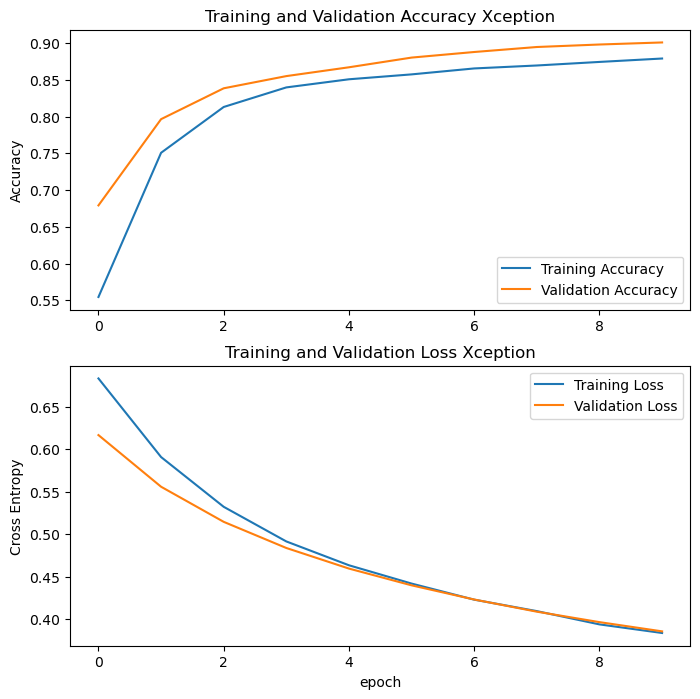

In [69]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Xception')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss Xception')
plt.xlabel('epoch')
plt.show()

On a eu un temps de calcul de 333 minutes et 12 secondes avec Xception et 10 epochs

### 5.3 VGG19 
On teste maintenant le modèle VGG19, qui est un modèle avec beaucoup plus de paramètres que Xception, ou mobilenetV2 afin de savoir si un modèle pré-entrainé avec plus un nombre de paramètres plus importants est plus efficace

In [10]:
base_model = tf.keras.applications.VGG19(input_shape=(img_width, img_height, 3),
                                               include_top=False,
                                               weights='imagenet')

In [11]:
base_model.trainable = False

In [12]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [13]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(2, activation = 'softmax')

In [14]:
preprocess_input = tf.keras.applications.vgg19.preprocess_input

In [15]:
inputs = tf.keras.Input(shape=(img_width, img_height, 3))
# x = preprocess_input(x)
x = inputs
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [16]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 2)                 1026      
                                                                 
Total params: 20025410 (76.39 MB)
Trainable params: 1026 (4.01 KB)
Non-trainable params: 20024384 (76.39 MB)
__________________

In [17]:
epochs = 10

# Ajouter le paramètre : validation_data=validation_generator)
# pour calculer la précision (accuracy) sur un répertoire de validation
history_VGG19 = model.fit(train_generator, validation_data=validation_generator, epochs=epochs)

Epoch 1/10
59/59 [==============================] - 5385s 91s/step - loss: 0.8187 - accuracy: 0.5195 - val_loss: 0.7774 - val_accuracy: 0.5000
Epoch 2/10
59/59 [==============================] - 4804s 81s/step - loss: 0.7507 - accuracy: 0.5262 - val_loss: 0.7176 - val_accuracy: 0.5000
Epoch 3/10
59/59 [==============================] - 4800s 81s/step - loss: 0.7074 - accuracy: 0.5445 - val_loss: 0.6803 - val_accuracy: 0.5098
Epoch 4/10
59/59 [==============================] - 4823s 82s/step - loss: 0.6800 - accuracy: 0.5806 - val_loss: 0.6572 - val_accuracy: 0.6116
Epoch 5/10
59/59 [==============================] - 4814s 82s/step - loss: 0.6628 - accuracy: 0.6210 - val_loss: 0.6409 - val_accuracy: 0.7280
Epoch 6/10
59/59 [==============================] - 4830s 82s/step - loss: 0.6504 - accuracy: 0.6558 - val_loss: 0.6274 - val_accuracy: 0.7834
Epoch 7/10
59/59 [==============================] - 5069s 86s/step - loss: 0.6389 - accuracy: 0.6833 - val_loss: 0.6150 - val_accuracy: 0.8122

In [18]:
pred_test=history_VGG19.model.predict(test_generator,verbose=1)


img_names = [w.replace('test_subfolder/','') for w in train_generator.filenames]
test_predictions = pd.read_csv(data_dir+'/template_predictions.csv', sep=";")
res = np.sort(test_predictions["name"])
pos = np.argsort(test_predictions["name"])
test_predictions["prediction"][pos] = pred_test.argmax(axis=-1)
pred = pred_test.argmax(axis=-1)
print(test_predictions[0:10])
test_predictions.to_csv("pred_model_val_accuracy_VGG19.csv",index=False, sep="\t")

5000/5000 [==============================] - 510s 102ms/step
     name  prediction
0   1.jpg         1.0
1   2.jpg         1.0
2   3.jpg         1.0
3   4.jpg         1.0
4   5.jpg         1.0
5   6.jpg         1.0
6   7.jpg         1.0
7   8.jpg         1.0
8   9.jpg         0.0
9  10.jpg         1.0


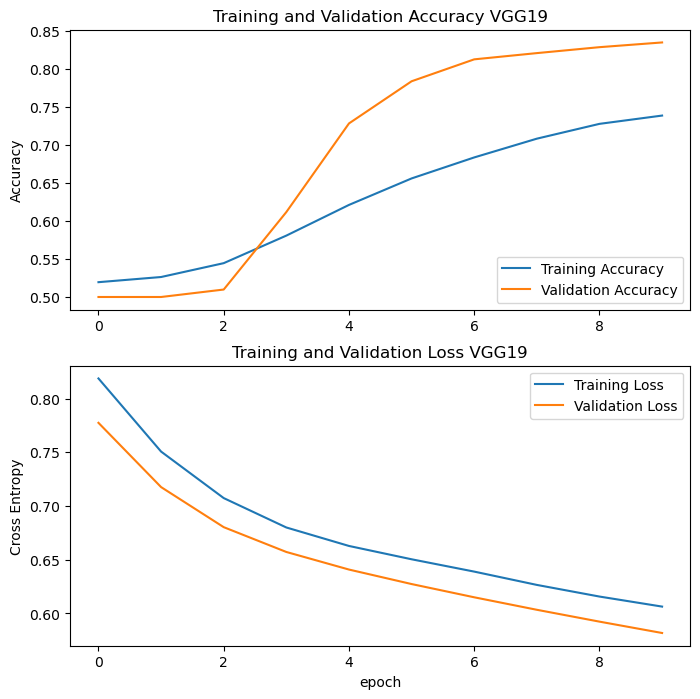

In [19]:
acc = history_VGG19.history['accuracy']
val_acc = history_VGG19.history['val_accuracy']

loss = history_VGG19.history['loss']
val_loss = history_VGG19.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy VGG19')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss VGG19')
plt.xlabel('epoch')
plt.show()

In [20]:
# chemin de l'enregistrement C:\Projet_Local_ML_MSS\Projet-classement-airbus-data\Data_Projet_TP3_Defi_IA
model.save('C:/Projet_Local_ML_MSS/Projet-classement-airbus-data/Data_Projet_TP3_Defi_IA/model_entrainés/VGG19/model_VGG19.h5')  # Pour le format HDF5

Avec VGG19 on a mis 819 minutes et 8.6 secondes pour l'entrainement

### 5.4 InceptionResNetV2

## 6 Réseau de neurones pré-entraîné et Fine Tuning

In [ ]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_7 (Dropout)         (None, 1280)              0         
                                                                 
 dense_31 (Dense)            (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 1864002 (

In [ ]:
fine_tune_epochs = 5
total_epochs =  epochs + fine_tune_epochs

history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         initial_epoch=history_1.epoch[-1],
                         validation_data= validation_generator)

Epoch 10/15
59/59 [==============================] - 1216s 20s/step - loss: 0.1998 - accuracy: 0.9261 - val_loss: 0.1325 - val_accuracy: 0.9542
Epoch 11/15
59/59 [==============================] - 1185s 20s/step - loss: 0.1622 - accuracy: 0.9416 - val_loss: 0.1286 - val_accuracy: 0.9528
Epoch 12/15
59/59 [==============================] - 1180s 20s/step - loss: 0.1498 - accuracy: 0.9453 - val_loss: 0.1161 - val_accuracy: 0.9604
Epoch 13/15
59/59 [==============================] - 1182s 20s/step - loss: 0.1373 - accuracy: 0.9499 - val_loss: 0.1166 - val_accuracy: 0.9586
Epoch 14/15
59/59 [==============================] - 1185s 20s/step - loss: 0.1330 - accuracy: 0.9518 - val_loss: 0.1110 - val_accuracy: 0.9610
Epoch 15/15
59/59 [==============================] - 1145s 19s/step - loss: 0.1276 - accuracy: 0.9545 - val_loss: 0.1106 - val_accuracy: 0.9616


In [80]:
pred_test=history_fine.model.predict(test_generator,verbose=1)

img_names = [w.replace('test_subfolder/','') for w in test_generator.filenames]
test_predictions = pd.read_csv(data_dir+'/template_predictions.csv', sep=";")
res = np.sort(test_predictions["name"])
pos = np.argsort(test_predictions["name"])
test_predictions["prediction"][pos] = pred_test.argmax(axis=-1)
pred = pred_test.argmax(axis=-1)

test_predictions.to_csv("pred_model_val_accuracy_0.9616.csv",index=False, sep="\t")

5000/5000 [==============================] - 112s 22ms/step


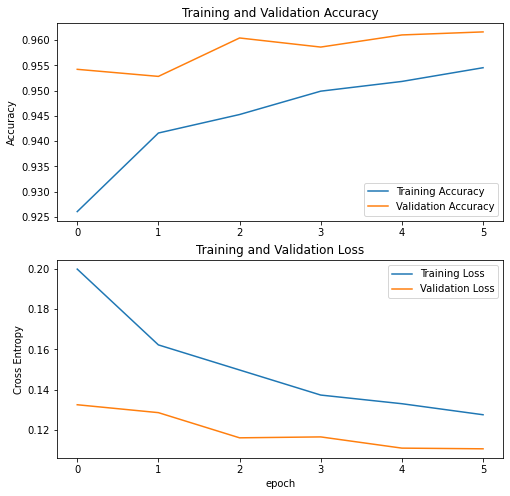

In [81]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 7 Conclusion

Résumé des résulats avec 10 epochs d'entraînement et 5 epochs de fine tuning  : 
- Modèle classique, 91.48% des données de l'ensemble test sont bien prédites.
- Modèle classique et fine tuning, 91.48% des données de l'ensemble test sont bien prédites.
- Modèle pré entraîné, 93.56% des données de l'ensemble test sont bien prédites.
- Modèle pré entraîné et fine tuning, 96.16% des données de l'ensemble test sont bien prédites.

Remarque 1 : Le fine tuning ne change rien lorsqu'on l'applique à un modèle classique (plutôt simple). Il a cependant un impact considérable sur la précision en étant appliqué sur le modèle pré entraîné. Cela peut s'expliquer par le fait que le modèle pré entraîné capte mieux les caractéristiques d'une image que le modèle simple. 

Remarque 2 : Lors du choix du modèle classique, nous avons d'abord entraîné un modèle avec beaucoup de paramètres (autour de 60 millions) pour le même nombre de couches. Ce dernier modèle produisait un effet de sur apprentissage. Nous avons donc changer l'architecture du modèle, afin de diminuer le nombre de paramètres et ne plus être temoin de surapprentissage.